# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.8 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

import matplotlib.pyplot as plt
from collections import deque
import torch
import pandas as pd

from ddpg_agent import Agent

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [5]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
agent2 = Agent(state_size=state_size, action_size=action_size, random_seed=1)

In [6]:
def ddpg(episodes=3000):
    scores_deque = deque(maxlen=100)
    scores = []
    #start running through episodes
    for episode in range(1, episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations  
        agent.reset()
        agent2.reset()
        score = np.zeros(num_agents)
        
        # start running through timesteps
        while True:
            # make actions based on env
            action = agent.act(states[0])
            action2 = agent2.act(states[1])
            env_info = env.step([action, action2])[brain_name]
            
            # get next state
            next_states = env_info.vector_observations
            # update rewards
            rewards = env_info.rewards
            dones = env_info.local_done
            
            #step with agent
            agent.step(states[0], action, rewards[0], next_states[0], dones[0])
            agent2.step(states[1], action2, rewards[1], next_states[1], dones[1])
            states = next_states
            score += rewards
            if any(dones):
                break 
        # update scores
        # np.max to get the highest of the 2 scores received
        score_pick = np.max(score)
        scores_deque.append(score_pick)
        scores.append(score_pick)
        
        #print scores, save checkpoints
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), '.checkpoint_critic.pth')
        torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor2.pth')
        torch.save(agent2.critic_local.state_dict(), '.checkpoint_critic2.pth')
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_deque)))
        # if avg above 0.5 over 100 episodes, we done
        if np.mean(scores_deque) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor2.pth')
            torch.save(agent2.critic_local.state_dict(), '.checkpoint_critic2.pth')
            break
            
    return scores

Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.01
Episode 300	Average Score: 0.01
Episode 400	Average Score: 0.01
Episode 500	Average Score: 0.01
Episode 600	Average Score: 0.03
Episode 700	Average Score: 0.05
Episode 800	Average Score: 0.04
Episode 900	Average Score: 0.07
Episode 1000	Average Score: 0.14
Episode 1100	Average Score: 0.16
Episode 1200	Average Score: 0.26
Episode 1300	Average Score: 0.29
Episode 1400	Average Score: 0.46
Episode 1500	Average Score: 0.37
Episode 1600	Average Score: 0.45
Episode 1621	Average Score: 0.50
Environment solved in 1521 episodes!	Average Score: 0.50


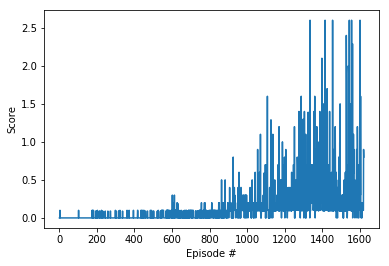

In [7]:
scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [8]:
env.close()